In [1]:
import torch
from gaussian_net import ImagePairDataset, set_seed
from torch.utils.data import random_split

device = "cuda"
set_seed(42)
orig_imgs = torch.load('dataset_raw/long_exp.pt', weights_only=True)
filter_imgs = torch.load('dataset_raw/filter_long_exp.pt', weights_only=True)

dataset = ImagePairDataset(orig_imgs.permute(0, 3, 1, 2), filter_imgs.permute(0, 3, 1, 2))
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

In [2]:
import importlib
import gaussian_net
importlib.reload(gaussian_net)
from gaussian_net import GaussianNet


net = GaussianNet(k_size=3).to(device)
net.load_state_dict(torch.load('net_chkpt.pth', weights_only=True))
net.eval()

GaussianNet(
  (enc1): Conv2d(4, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (encoder_sigma): Sequential(
    (0): Conv2d(4, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (dec1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec4): ConvTranspose2d(16

Image size after demosaic_vanilla:  (512, 512, 3)
Image size after demosaic_vanilla:  (512, 512, 3)


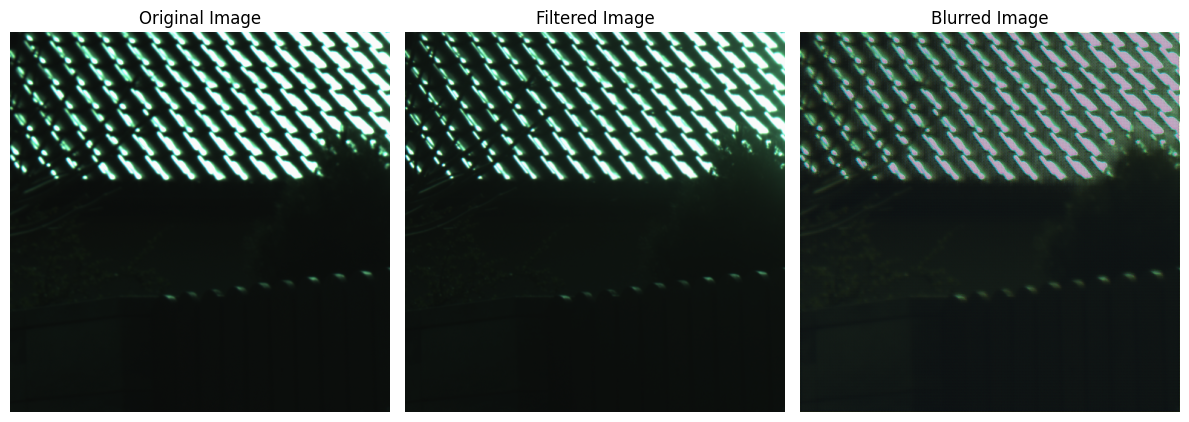

In [ ]:
from raw_utils import unpack_raw, demosaic_vanilla, demosaic_bilinear
from matplotlib import pyplot as plt
from gaussian_net import set_seed
from raw_utils import white_balance_gray_world
import numpy as np

def postprocess(image):
    rgb = demosaic_bilinear(unpack_raw(image))
    # White balance gray world
    # rgb = rgb / np.mean(rgb, axis=(0, 1), keepdims=True)
    # channel means
    mu = rgb.mean(axis=(0,1))              # [μ_R, μ_G, μ_B]
    mu_gray = mu.mean()                  # gray reference
    scales = mu_gray / mu                # [s_R, s_G, s_B]
    # apply scales
    rgb = rgb * scales[None,None,:]

    rgb = np.clip(rgb, 0, 1)
    # Apply gamma correction
    gamma = 2.2
    rgb = np.power(rgb, 1 / gamma)
    # Normalize to [0, 1]
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    return rgb

i = 8

value = train_dataset[i]
#value = test_dataset[i]
orig_value = value[0].unsqueeze(0).cuda()
filtered_value = value[1].unsqueeze(0).cuda()

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(demosaic_vanilla(unpack_raw(orig_value.squeeze().permute(1, 2, 0).cpu().numpy())))
plt.title("Original Image")
plt.axis("off")


plt.subplot(1, 3, 2)
plt.imshow(demosaic_vanilla(unpack_raw(filtered_value.squeeze().permute(1, 2, 0).cpu().numpy())))
plt.title("Filtered Image")
plt.axis("off")

plt.subplot(1, 3, 3)
# plt.imshow(demosaic_vanilla(unpack_raw(np.clip(net(orig_value).squeeze().permute(1, 2, 0).detach().cpu().numpy(), 0, 1))))
plt.imshow(np.clip(net(orig_value).squeeze().permute(1, 2, 0).detach().cpu().numpy(), 0, 1))
plt.title("Blurred Image")
plt.axis("off")


plt.tight_layout()
plt.show()

In [10]:
orig_value.squeeze().mean(dim=(1, 2)), filtered_value.squeeze().mean(dim=(1, 2)), net(orig_value).squeeze().mean(dim=(1, 2))

(tensor([0.2481, 0.5101, 0.4454, 0.5087], device='cuda:0'),
 tensor([0.2210, 0.4518, 0.3870, 0.4505], device='cuda:0'),
 tensor([0.2389, 0.4300, 0.3848, 0.4332], device='cuda:0',
        grad_fn=<MeanBackward1>))